I trained all the models on Kaggle and hence the file paths are according to them. If running locally, replace them with the commented one beside them (they are fixed in beginning of the code only).<br> Also change for the test dataset accordingly

In [7]:
# Importing required libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from torchvision import models, transforms
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import os
from tqdm import tqdm
from scipy.sparse import issparse

In [8]:
# Configurations & Reproducibility

data_path = '/kaggle/input/tabular-data/' # '../data/processed/'
image_dir = '/kaggle/input/imagery-train/' # '../data/images/train/images/'
save_model_dir = '/kaggle/working/' # '/model_output/'

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)
print("Random seed set to 42")

Random seed set to 42


In [9]:
# DATASET CLASS
class MultimodalDataset(Dataset):
    def __init__(self, X_tabular, y_labels, property_ids, image_dir, transform=None):
        self.X_tabular = torch.FloatTensor(X_tabular)
        self.y_labels = torch.FloatTensor(y_labels)
        self.property_ids = property_ids
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.property_ids)

    def __getitem__(self, idx):
        # Load Tabular
        tabular_features = self.X_tabular[idx]
        label = self.y_labels[idx]

        # Load Image
        property_id = self.property_ids[idx]
        image_path = os.path.join(self.image_dir, f"{property_id}.png")

        try:
            image = Image.open(image_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), color='black') # Fallback

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'tabular': tabular_features,
            'label': label,
            'id': property_id
        }

In [10]:
# MODEL ARCHITECTURE
class MultimodalModel(nn.Module):
    def __init__(self, tabular_input_dim):
        super(MultimodalModel, self).__init__()

        # A. Vision Branch: ResNet50
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        cnn_out_dim = self.resnet.fc.in_features  # 2048 for ResNet50
        self.resnet.fc = nn.Identity() # Remove classification head

        # B. Stabilized Tabular Branch
        self.tabular_mlp = nn.Sequential(
            nn.Linear(tabular_input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        tabular_out_dim = 128

        # C. Fusion Head
        self.fusion = nn.Sequential(
            nn.Linear(cnn_out_dim + tabular_out_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1) # Output: Log Price
        )

        # Initialize the final bias to mean log-price (around 13.0) to speed up convergence
        nn.init.constant_(self.fusion[-1].bias, 13.0)

    def forward(self, img, tab):
        img_feats = self.resnet(img)

        tab_feats = self.tabular_mlp(tab)

        # We scale image features down initially so the model prioritizes tabular data
        combined = torch.cat((img_feats * 0.1, tab_feats), dim=1)

        return self.fusion(combined).squeeze(-1)

In [11]:
# LOADING DATA
print("Loading data...")

if os.path.exists(f'{data_path}X_train.npy'):
    X_train = np.load(f'{data_path}X_train.npy', allow_pickle=True)
    y_train = np.load(f'{data_path}y_train.npy', allow_pickle=True)
    train_ids = np.load(f'{data_path}train_ids.npy', allow_pickle=True)
    X_val = np.load(f'{data_path}X_val.npy', allow_pickle=True)
    y_val = np.load(f'{data_path}y_val.npy', allow_pickle=True)
    val_ids = np.load(f'{data_path}val_ids.npy', allow_pickle=True)

    # Handle Sparse/Wrapped Inputs
    if X_train.shape == (): X_train = X_train.item()
    if X_val.shape == (): X_val = X_val.item()
    if issparse(X_train): X_train = X_train.toarray().astype(np.float32)
    else: X_train = np.array(X_train, dtype=np.float32)
    if issparse(X_val): X_val = X_val.toarray().astype(np.float32)
    else: X_val = np.array(X_val, dtype=np.float32)

    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)
    print(f"Data Loaded. Train: {X_train.shape}, Val: {X_val.shape}")
else:
    raise FileNotFoundError("Please run the preprocessing script to generate .npy files first.")

# Standard Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MultimodalDataset(X_train, y_train, train_ids, image_dir, transform)
val_dataset = MultimodalDataset(X_val, y_val, val_ids, image_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

Loading data...
Data Loaded. Train: (12888, 64), Val: (3222, 64)


In [12]:
# TRAINING SETUP
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MultimodalModel(tabular_input_dim=X_train.shape[1]).to(device)

# Initially freeze all ResNet layers
for param in model.resnet.parameters():
    param.requires_grad = False
print("Vision backbone frozen (Stage 1: Tabular Data Dominance)")

criterion = nn.MSELoss()
# Differential Learning Rates: Low for CNN, Higher for MLP
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-5},
    {'params': model.tabular_mlp.parameters(), 'lr': 1e-3},
    {'params': model.fusion.parameters(), 'lr': 1e-3}
])

# Scheduler: Reduce LR if validation RMSE stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# TRAINING LOOP
num_epochs = 30
best_val_rmse = float('inf')
unfreeze_epoch = 10  # Start fine-tuning CNN at epoch 10

print(f"\nStarting training Loop ({num_epochs} epochs)...")

for epoch in range(num_epochs):
    model.train()

    # STAGE 2: Unfreeze Vision Backbone
    if epoch == unfreeze_epoch:
        print("\nUNFREEZING ResNet50 (Stage 2: Visual Refining)...")
        # Only unfreeze the last 2 layers of ResNet to prevent overfitting
        for name, child in model.resnet.named_children():
            if name in ['layer3', 'layer4']:
                for param in child.parameters():
                    param.requires_grad = True
        print("Layer3 and Layer4 unfrozen for fine-tuning")

    train_losses = []

    # Progress Bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

    for batch in pbar:
        images = batch['image'].to(device)
        tabular = batch['tabular'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, tabular)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Validation
    model.eval()
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            tabular = batch['tabular'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, tabular)
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    # Metrics
    val_preds = np.array(val_preds)
    val_targets = np.array(val_targets)
    epoch_val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    epoch_val_r2 = r2_score(val_targets, val_preds)
    avg_train_loss = np.mean(train_losses)

    # Update Scheduler
    scheduler.step(epoch_val_rmse)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val RMSE: {epoch_val_rmse:.4f} | Val R2: {epoch_val_r2:.4f}")

    # Save Best Model
    if epoch_val_rmse < best_val_rmse:
        best_val_rmse = epoch_val_rmse
        torch.save(model.state_dict(), f"{save_model_dir}best_multimodal_model.pth")
        print(f"  Saved new best model (RMSE: {best_val_rmse:.4f})")

print("\nTraining Complete.")

Using device: cuda
Vision backbone frozen (Stage 1: Tabular Data Dominance)

Starting training Loop (30 epochs)...


Epoch 1 | Train Loss: 0.0713 | Val RMSE: 0.2190 | Val R2: 0.8231
  Saved new best model (RMSE: 0.2190)


Epoch 2 | Train Loss: 0.0550 | Val RMSE: 0.1887 | Val R2: 0.8688
  Saved new best model (RMSE: 0.1887)


Epoch 3 | Train Loss: 0.0500 | Val RMSE: 0.1962 | Val R2: 0.8581


Epoch 4 | Train Loss: 0.0475 | Val RMSE: 0.1852 | Val R2: 0.8736
  Saved new best model (RMSE: 0.1852)


Epoch 5 | Train Loss: 0.0444 | Val RMSE: 0.1907 | Val R2: 0.8660


Epoch 6 | Train Loss: 0.0428 | Val RMSE: 0.1864 | Val R2: 0.8719


Epoch 7 | Train Loss: 0.0417 | Val RMSE: 0.1897 | Val R2: 0.8673


Epoch 8 | Train Loss: 0.0369 | Val RMSE: 0.1822 | Val R2: 0.8776
  Saved new best model (RMSE: 0.1822)


Epoch 9 | Train Loss: 0.0356 | Val RMSE: 0.1806 | Val R2: 0.8798
  Saved new best model (RMSE: 0.1806)


Epoch 10 | Train Loss: 0.0359 | Val RMSE: 0.1804 | Val R2: 0.8800
  Saved new best model (RMSE: 0.1804)

UNFREEZING ResNet50 (Stage 2: Visual Refining)...
Layer3 and Layer4 unfrozen for fine-tuning


Epoch 11 | Train Loss: 0.0352 | Val RMSE: 0.1807 | Val R2: 0.8797


Epoch 12 | Train Loss: 0.0346 | Val RMSE: 0.1804 | Val R2: 0.8800
  Saved new best model (RMSE: 0.1804)


Epoch 13 | Train Loss: 0.0334 | Val RMSE: 0.1792 | Val R2: 0.8816
  Saved new best model (RMSE: 0.1792)


Epoch 14 | Train Loss: 0.0332 | Val RMSE: 0.1790 | Val R2: 0.8819
  Saved new best model (RMSE: 0.1790)


Epoch 15 | Train Loss: 0.0324 | Val RMSE: 0.1797 | Val R2: 0.8809


Epoch 16 | Train Loss: 0.0318 | Val RMSE: 0.1802 | Val R2: 0.8803


Epoch 17 | Train Loss: 0.0304 | Val RMSE: 0.1818 | Val R2: 0.8782


Epoch 18 | Train Loss: 0.0301 | Val RMSE: 0.1804 | Val R2: 0.8800


Epoch 19 | Train Loss: 0.0300 | Val RMSE: 0.1793 | Val R2: 0.8814


Epoch 20 | Train Loss: 0.0292 | Val RMSE: 0.1805 | Val R2: 0.8798


Epoch 21 | Train Loss: 0.0295 | Val RMSE: 0.1809 | Val R2: 0.8794


Epoch 22 | Train Loss: 0.0291 | Val RMSE: 0.1815 | Val R2: 0.8786


Epoch 23 | Train Loss: 0.0296 | Val RMSE: 0.1811 | Val R2: 0.8792


Epoch 24 | Train Loss: 0.0297 | Val RMSE: 0.1800 | Val R2: 0.8805


Epoch 25 | Train Loss: 0.0286 | Val RMSE: 0.1814 | Val R2: 0.8787


Epoch 26 | Train Loss: 0.0295 | Val RMSE: 0.1798 | Val R2: 0.8808


Epoch 27 | Train Loss: 0.0293 | Val RMSE: 0.1811 | Val R2: 0.8790


Epoch 28 | Train Loss: 0.0294 | Val RMSE: 0.1812 | Val R2: 0.8789


Epoch 29 | Train Loss: 0.0291 | Val RMSE: 0.1815 | Val R2: 0.8785


Epoch 30 | Train Loss: 0.0293 | Val RMSE: 0.1795 | Val R2: 0.8812

Training Complete.


After Epoch 15, the model didn't improved and hence 15 (or 20) epochs would've been enough

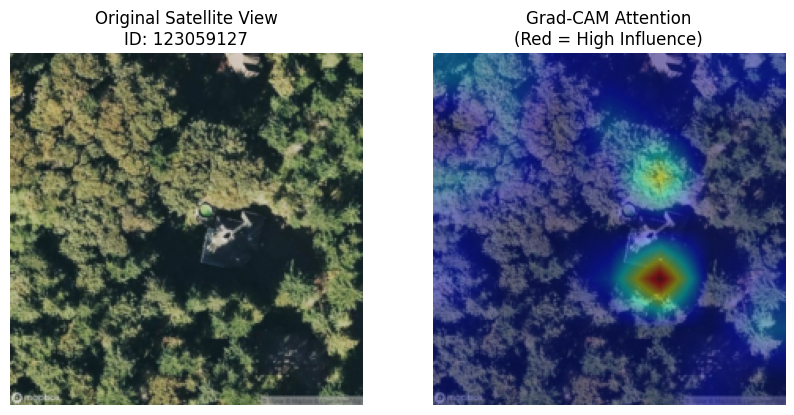

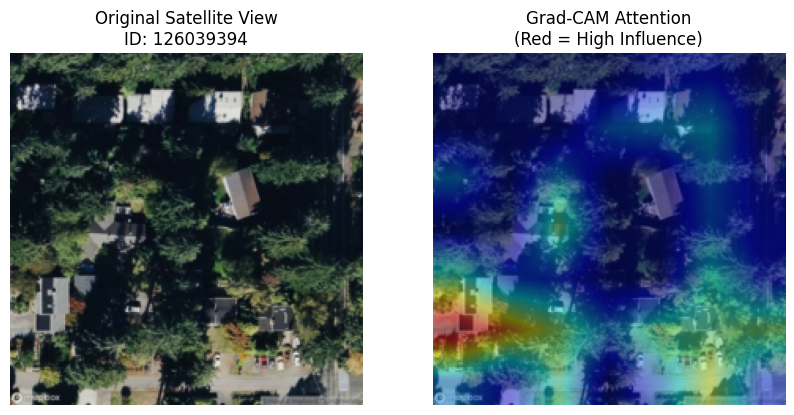

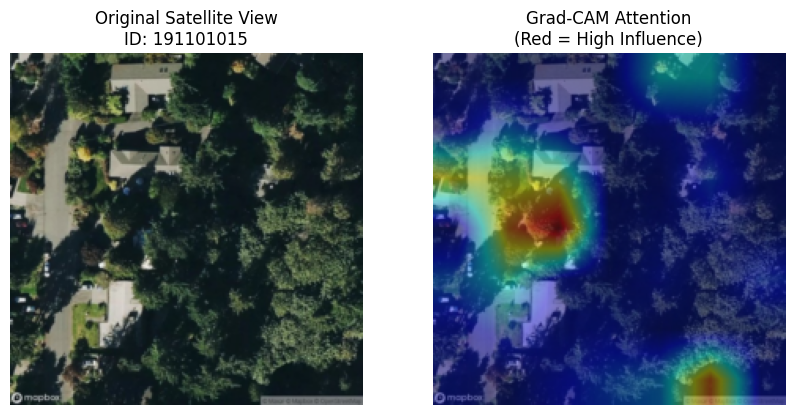

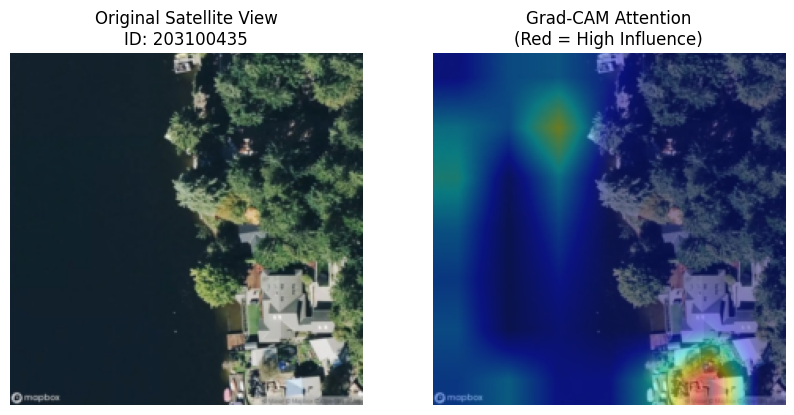

ID 203100625 not found in dataset.


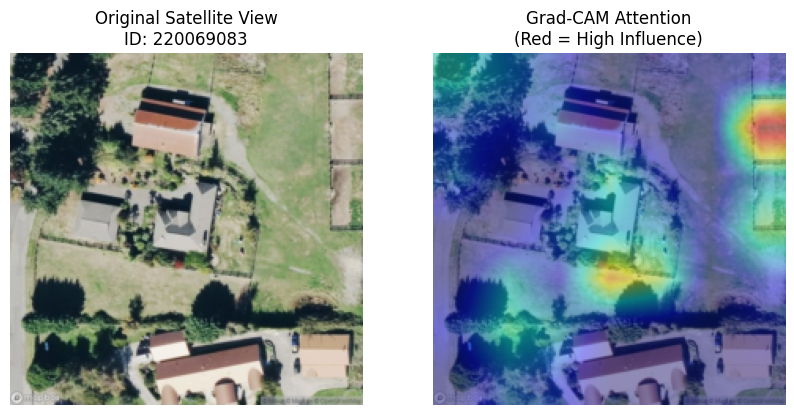

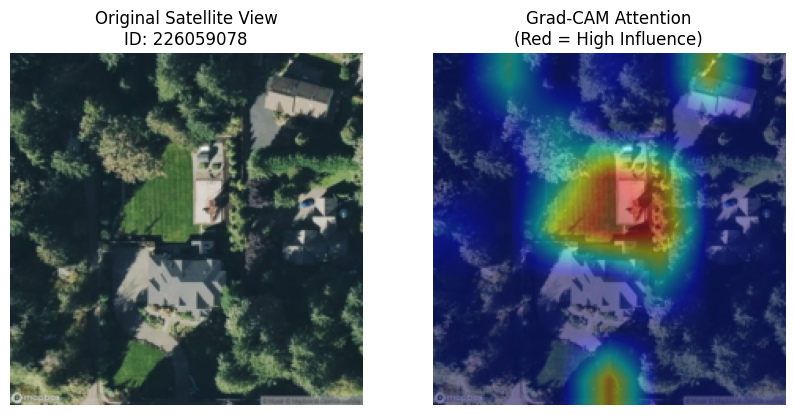

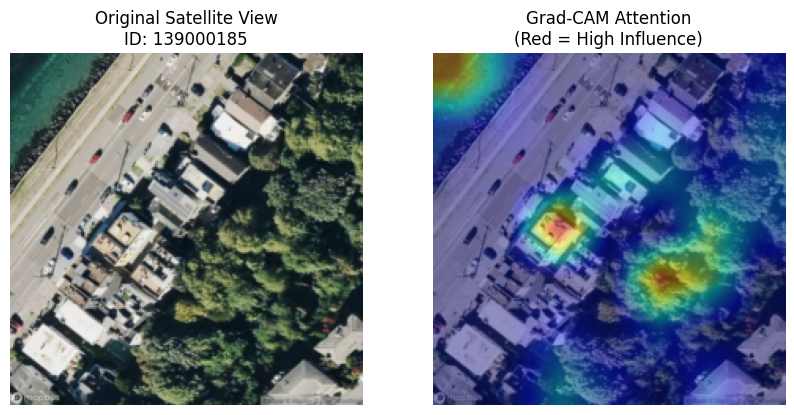

In [36]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

def generate_gradcam(model, image_tensor, tabular_tensor, device):

    #Generates a Grad-CAM heatmap for a specific input image.
    model.eval()

    # Hook into the last convolutional layer of ResNet50
    target_layer = model.resnet.layer4[-1]

    # Storage for gradients and activations
    gradients = []
    activations = []

    def save_gradient(grad):
        gradients.append(grad)

    def save_activation(module, input, output):
        activations.append(output)


    handle_grad = target_layer.register_full_backward_hook(lambda m, i, o: save_gradient(o[0]))
    handle_act = target_layer.register_forward_hook(save_activation)

    # Forward Pass
    image_tensor = image_tensor.to(device).unsqueeze(0)
    tabular_tensor = tabular_tensor.to(device).unsqueeze(0)
    image_tensor.requires_grad = True

    output = model(image_tensor, tabular_tensor)

    # Backward Pass
    model.zero_grad()
    output.backward()

    # Compute Grad-CAM
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3]).cpu()

    activation = activations[0].detach().cpu().squeeze(0) # [2048, 7, 7]

    # Weight the channels by corresponding gradients
    for i in range(activation.shape[0]):
        activation[i, :, :] *= pooled_gradients[i]

    # Average the channels to get the heatmap
    heatmap = torch.mean(activation, dim=0).numpy()

    heatmap = np.maximum(heatmap, 0)

    # Normalize heatmap
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    # Cleanup hooks
    handle_grad.remove()
    handle_act.remove()

    return heatmap

def plot_gradcam(model, dataset, property_id, device):

    #Finds a property by ID, generates Grad-CAM, and overlays it on the image.

    try:
        idx = list(dataset.property_ids).index(property_id)
    except ValueError:
        print(f"ID {property_id} not found in dataset.")
        return

    # Get data
    data = dataset[idx]
    img_tensor = data['image']
    tab_tensor = data['tabular']
    original_img = img_tensor.permute(1, 2, 0).numpy()

    # Un-normalize for display (ImageNet stats)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    original_img = std * original_img + mean
    original_img = np.clip(original_img, 0, 1)

    # Generate Heatmap
    heatmap = generate_gradcam(model, img_tensor, tab_tensor, device)

    heatmap_resized = cv2.resize(heatmap, (224, 224))

    # Convert to color map
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0

    # Overlay
    superimposed_img = heatmap_colored * 0.4 + original_img * 0.6

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_img)
    ax[0].set_title(f"Original Satellite View\nID: {property_id}")
    ax[0].axis('off')

    ax[1].imshow(superimposed_img)
    ax[1].set_title(f"Grad-CAM Attention\n(Red = High Influence)")
    ax[1].axis('off')

    plt.savefig(f"heatmap_{property_id}.png", bbox_inches='tight', dpi=300)
    plt.show()

# Loading the best model checkpoint
model.load_state_dict(torch.load(f"{save_model_dir}best_multimodal_model.pth"))

sample_ids = [123059127, 126039394, 191101015, 203100435, 203100625, 220069083, 226059078, 139000185]

for pid in sample_ids:
    plot_gradcam(model, val_dataset, pid, device)
for pid in sample_ids:
    plot_gradcam(model, train_dataset, pid, device)

The Grad-CAM heatmaps shows that the model generally shifts its focus away from the primary residential structure and toward external environmental context, such as waterfronts, neighboring density and mature tree canopies. This confirms the CNN validates "curb appeal" and location quality, capturing critical non-tabular context to refine price predictions.